In [32]:
# import argparse

class HParams(object):
	def __init__(self):
		# Dataset Settings
		self.dataset_path = 'd:/다운로드/gtzan'
		self.feature_path = 'feature4'
		self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

		# Feature Parameters
		self.sample_rate = 22050
		self.fft_size = 1024
		self.win_size = 1024
		self.hop_size = 512
		self.num_mels = 128
		self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

		# Training Parameters
		self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
		self.batch_size = 20
		self.num_epochs = 100
		self.learning_rate = 3*1e-5
		self.stopping_rate = 1e-12
		self.weight_decay = 1e-6
		self.momentum = 0.9
		self.factor = 0.2
		self.patience = 3.

hparams = HParams()

In [33]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

class GTZANDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

# Function to get genre index for the give file
def get_label(file_name, hparams):
    genre = file_name.split('.')[0]
    label = hparams.genres.index(genre)
    return label

def load_dataset(set_name, hparams): #모든 데이터 읽어오기, 
    x = []
    y = []

    dataset_path = os.path.join(hparams.feature_path, set_name)
    for root,dirs,files in os.walk(dataset_path):
        for file in files:
            data = np.load(os.path.join(root,file))
            label = get_label(file, hparams)
            x.append(data)
            y.append(label)
            torch.cuda.empty_cache() 

    x = np.stack(x)
    y = np.stack(y)

    return x,y

def get_dataloader(hparams):
    x_train, y_train = load_dataset('train', hparams)
    torch.cuda.empty_cache() 
    x_valid, y_valid = load_dataset('valid', hparams)
    x_test, y_test = load_dataset('test', hparams)

    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean)/std
    x_valid = (x_valid - mean)/std
    x_test = (x_test - mean)/std

    train_set = GTZANDataset(x_train, y_train)
    vaild_set = GTZANDataset(x_valid, y_valid)
    test_set = GTZANDataset(x_test, y_test)

    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True, drop_last=False)
    valid_loader = DataLoader(vaild_set, batch_size=hparams.batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_set, batch_size=hparams.batch_size, shuffle=False, drop_last=False)

    return train_loader, valid_loader, test_loader

In [16]:
x_valid, y_valid = load_dataset('valid', hparams)

In [23]:
torch.cuda.empty_cache() 

In [27]:
x_train, y_train = load_dataset('train', hparams)

In [28]:
x_train.shape

NameError: name 'x_train' is not defined

In [28]:
x_train.shape

(3840, 1536, 128)

In [4]:
# train_loader, valid_loader, test_loader = get_dataloader(hparams)

In [34]:
'''
train_test.py
A file for training model for genre classification.
Please check the device in hparams.py before you run this code.
'''
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt

# import data_manager
# import models
# from hparams import hparams

# Wrapper class to run PyTorch model
class Runner(object):
    def __init__(self, hparams):
        self.model = Baseline(hparams)
        self.criterion = nn.CrossEntropyLoss()
        
        #self.optimizer = torch.optim.Adam(self.model.parameters(), lr=hparams.learning_rate)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=hparams.learning_rate, momentum=hparams.momentum)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=hparams.factor, patience=hparams.patience, verbose=True)
        self.learning_rate = hparams.learning_rate
        self.stopping_rate = hparams.stopping_rate
        self.device = torch.device("cpu")

        if hparams.device > 0:
            torch.cuda.set_device(hparams.device - 1)##
            self.model.cuda(hparams.device - 1)
            self.criterion.cuda(hparams.device - 1)
            self.device = torch.device("cuda:" + str(hparams.device - 1))
            
#         device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#         self.model = Baseline(hparams).to(device)
#         if torch.cuda.device_count() > 1:
#             print('\n===> Training on GPU!')
#             self.model = nn.DataParallel(net)

    # Accuracy function works like loss function in PyTorch
    def accuracy(self, source, target):
        source = source.max(1)[1].long().cpu()
        target = target.cpu()
        correct = (source == target).sum().item()

        return correct/float(source.size(0))

    # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
    def run(self, dataloader, mode='train'):
        self.model.train() if mode is 'train' else self.model.eval()

        epoch_loss = 0.0
        epoch_acc = 0.0
        
        for batch, (x, y) in enumerate(dataloader):
            x = x.to(self.device)
            y = y.to(self.device).type(torch.long)
            
            #print(y)

            prediction = self.model(x)
            loss = self.criterion(prediction, y)
            acc = self.accuracy(prediction, y)

            if mode is 'train':
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            epoch_loss += prediction.size(0)*loss.item()
            epoch_acc += prediction.size(0)*acc

        epoch_loss = epoch_loss/len(dataloader.dataset)
        epoch_acc = epoch_acc/len(dataloader.dataset)

        return epoch_loss, epoch_acc

    # Early stopping function for given validation loss
    def early_stop(self, loss, epoch):
        self.scheduler.step(loss, epoch)
        self.learning_rate = self.optimizer.param_groups[0]['lr']
        stop = self.learning_rate < self.stopping_rate

        return stop

def device_name(device):
    if device == 0:
        device_name = 'CPU'
    else:
        device_name = 'GPU:' + str(device - 1)

    return device_name

def main():  
    train_loader, valid_loader, test_loader = get_dataloader(hparams)
    runner = Runner(hparams)
    val_loss_ls =[]
    train_loss_ls =[]

    print('Training on ' + device_name(hparams.device))
    for epoch in range(hparams.num_epochs):
        train_loss, train_acc = runner.run(train_loader, 'train')
        valid_loss, valid_acc = runner.run(valid_loader, 'eval')
        if((epoch+1)%10==0):
            print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
                  (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))
            
        val_loss_ls.append(valid_loss)
        train_loss_ls.append(train_loss)
        
        if runner.early_stop(valid_loss, epoch + 1):
            break

    test_loss, test_acc = runner.run(test_loader, 'eval')
    print("Training Finished")
    print("Test Accuracy: %.2f%%" % (100*test_acc))
    
    plt.plot(val_loss_ls,'r')
    plt.plot(train_loss_ls,'b')
    plt.show()
    

In [35]:
'''
CNN 계층 증가
Dropout 추가 1, 6
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        self._initialize_weights()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(128, 96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(96),
        nn.ReLU(),
        nn.MaxPool1d(6, stride=6)
        )

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(96, 117),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)+x1 #Resnet1
        x = torch.cat((self.conv2_1(x)+self.conv2_2(x),self.conv2_2(x)+self.conv2_1(x)),2)
        x = self.conv3(x)
        x = x+x2#Resnet 2  
        x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fand_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0.8)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0.8)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias,0.8)

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.9137] [Train Acc: 0.3133] [Valid Loss: 1.9728] [Valid Acc: 0.2562]
[Epoch 20/100] [Train Loss: 1.8139] [Train Acc: 0.5078] [Valid Loss: 1.9116] [Valid Acc: 0.3563]
[Epoch 30/100] [Train Loss: 1.7266] [Train Acc: 0.5969] [Valid Loss: 1.8385] [Valid Acc: 0.4562]
[Epoch 40/100] [Train Loss: 1.6415] [Train Acc: 0.6180] [Valid Loss: 1.7628] [Valid Acc: 0.4813]
[Epoch 50/100] [Train Loss: 1.5349] [Train Acc: 0.6648] [Valid Loss: 1.6780] [Valid Acc: 0.5125]
[Epoch 60/100] [Train Loss: 1.4436] [Train Acc: 0.6797] [Valid Loss: 1.6014] [Valid Acc: 0.5500]
[Epoch 70/100] [Train Loss: 1.3350] [Train Acc: 0.7008] [Valid Loss: 1.5121] [Valid Acc: 0.5687]
[Epoch 80/100] [Train Loss: 1.2151] [Train Acc: 0.7242] [Valid Loss: 1.4259] [Valid Acc: 0.6188]
[Epoch 90/100] [Train Loss: 1.1272] [Train Acc: 0.7648] [Valid Loss: 1.3427] [Valid Acc: 0.6625]
[Epoch 100/100] [Train Loss: 1.0412] [Train Acc: 0.7828] [Valid Loss: 1.2748] [Valid Acc: 0.6813]
Training Fi

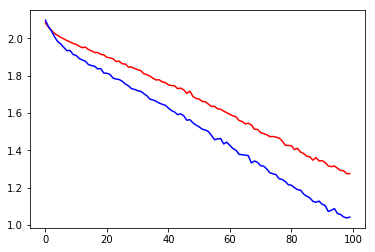

In [6]:
main()

In [7]:
hparams.learning_rate = 5*1e-6
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

Training on GPU:0
[Epoch 10/100] [Train Loss: 2.0584] [Train Acc: 0.2250] [Valid Loss: 2.0671] [Valid Acc: 0.2188]
[Epoch 20/100] [Train Loss: 2.0273] [Train Acc: 0.2633] [Valid Loss: 2.0369] [Valid Acc: 0.2562]
[Epoch 30/100] [Train Loss: 2.0029] [Train Acc: 0.3039] [Valid Loss: 2.0153] [Valid Acc: 0.2750]
[Epoch 40/100] [Train Loss: 1.9771] [Train Acc: 0.3352] [Valid Loss: 1.9983] [Valid Acc: 0.2938]
[Epoch 50/100] [Train Loss: 1.9598] [Train Acc: 0.3508] [Valid Loss: 1.9866] [Valid Acc: 0.2938]
[Epoch 60/100] [Train Loss: 1.9467] [Train Acc: 0.3523] [Valid Loss: 1.9741] [Valid Acc: 0.2938]
[Epoch 70/100] [Train Loss: 1.9283] [Train Acc: 0.3805] [Valid Loss: 1.9609] [Valid Acc: 0.3000]
[Epoch 80/100] [Train Loss: 1.9090] [Train Acc: 0.3805] [Valid Loss: 1.9512] [Valid Acc: 0.3250]
[Epoch 90/100] [Train Loss: 1.8963] [Train Acc: 0.3961] [Valid Loss: 1.9384] [Valid Acc: 0.3063]
[Epoch 100/100] [Train Loss: 1.8841] [Train Acc: 0.4117] [Valid Loss: 1.9283] [Valid Acc: 0.3187]
Training Fi

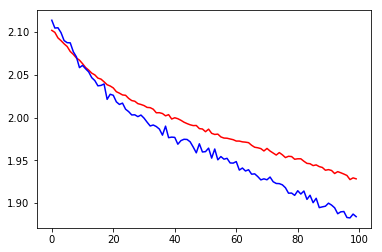

In [8]:
main()

In [9]:
hparams.learning_rate = 1e-4

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.7666] [Train Acc: 0.5273] [Valid Loss: 1.8324] [Valid Acc: 0.4500]
[Epoch 20/100] [Train Loss: 1.4716] [Train Acc: 0.6492] [Valid Loss: 1.5819] [Valid Acc: 0.5500]
[Epoch 30/100] [Train Loss: 1.1428] [Train Acc: 0.7594] [Valid Loss: 1.3350] [Valid Acc: 0.6062]
[Epoch 40/100] [Train Loss: 0.8797] [Train Acc: 0.8195] [Valid Loss: 1.1329] [Valid Acc: 0.6937]
[Epoch 50/100] [Train Loss: 0.6394] [Train Acc: 0.8875] [Valid Loss: 0.9597] [Valid Acc: 0.7250]
[Epoch 60/100] [Train Loss: 0.4816] [Train Acc: 0.9125] [Valid Loss: 0.8872] [Valid Acc: 0.7438]
[Epoch 70/100] [Train Loss: 0.3748] [Train Acc: 0.9414] [Valid Loss: 0.8370] [Valid Acc: 0.7562]
Epoch    79: reducing learning rate of group 0 to 2.0000e-05.
[Epoch 80/100] [Train Loss: 0.2822] [Train Acc: 0.9609] [Valid Loss: 0.8140] [Valid Acc: 0.7375]
Epoch    85: reducing learning rate of group 0 to 4.0000e-06.
Epoch    89: reducing learning rate of group 0 to 8.0000e-07.
[Epoch 90/100] [Trai

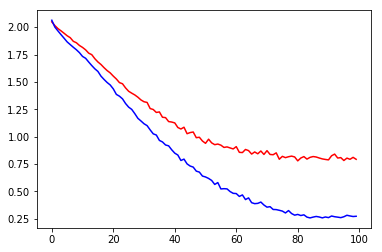

In [10]:
main()

In [11]:
hparams.learning_rate = 3*1e-4

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.2071] [Train Acc: 0.7359] [Valid Loss: 1.3838] [Valid Acc: 0.5938]
[Epoch 20/100] [Train Loss: 0.5449] [Train Acc: 0.8930] [Valid Loss: 0.9193] [Valid Acc: 0.7375]
[Epoch 30/100] [Train Loss: 0.2553] [Train Acc: 0.9578] [Valid Loss: 0.8437] [Valid Acc: 0.7625]
Epoch    31: reducing learning rate of group 0 to 6.0000e-05.
Epoch    38: reducing learning rate of group 0 to 1.2000e-05.
[Epoch 40/100] [Train Loss: 0.1747] [Train Acc: 0.9836] [Valid Loss: 0.8298] [Valid Acc: 0.7500]
Epoch    42: reducing learning rate of group 0 to 2.4000e-06.
Epoch    46: reducing learning rate of group 0 to 4.8000e-07.
[Epoch 50/100] [Train Loss: 0.1926] [Train Acc: 0.9781] [Valid Loss: 0.8532] [Valid Acc: 0.7625]
Epoch    50: reducing learning rate of group 0 to 9.6000e-08.
Epoch    54: reducing learning rate of group 0 to 1.9200e-08.
Epoch    58: reducing learning rate of group 0 to 3.8400e-09.
[Epoch 60/100] [Train Loss: 0.1933] [Train Acc: 0.9711] [Valid 

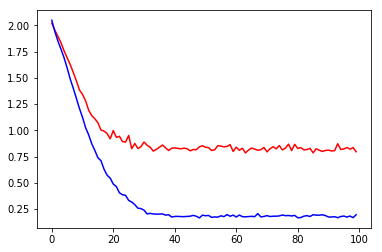

In [12]:
main()

In [13]:
hparams.learning_rate = 2*1e-4

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.4410] [Train Acc: 0.6664] [Valid Loss: 1.5834] [Valid Acc: 0.4437]
[Epoch 20/100] [Train Loss: 0.8435] [Train Acc: 0.8203] [Valid Loss: 1.1558] [Valid Acc: 0.6813]
[Epoch 30/100] [Train Loss: 0.4604] [Train Acc: 0.9227] [Valid Loss: 0.9609] [Valid Acc: 0.6687]
Epoch    39: reducing learning rate of group 0 to 4.0000e-05.
[Epoch 40/100] [Train Loss: 0.2816] [Train Acc: 0.9594] [Valid Loss: 0.8873] [Valid Acc: 0.7000]
Epoch    43: reducing learning rate of group 0 to 8.0000e-06.
Epoch    47: reducing learning rate of group 0 to 1.6000e-06.
[Epoch 50/100] [Train Loss: 0.2614] [Train Acc: 0.9547] [Valid Loss: 0.9144] [Valid Acc: 0.6750]
Epoch    58: reducing learning rate of group 0 to 3.2000e-07.
[Epoch 60/100] [Train Loss: 0.2493] [Train Acc: 0.9648] [Valid Loss: 0.8843] [Valid Acc: 0.7000]
Epoch    62: reducing learning rate of group 0 to 6.4000e-08.
Epoch    66: reducing learning rate of group 0 to 1.2800e-08.
[Epoch 70/100] [Train Loss: 

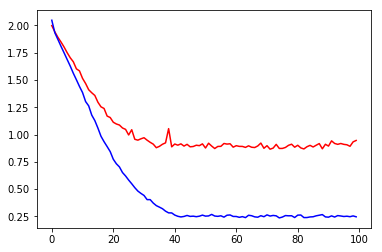

In [14]:
main()

In [6]:
hparams.learning_rate = 6*1e-4

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.5909] [Train Acc: 0.8828] [Valid Loss: 0.9920] [Valid Acc: 0.7125]
Epoch    19: reducing learning rate of group 0 to 1.2000e-04.
[Epoch 20/100] [Train Loss: 0.1659] [Train Acc: 0.9750] [Valid Loss: 0.6926] [Valid Acc: 0.7688]
[Epoch 30/100] [Train Loss: 0.1003] [Train Acc: 0.9938] [Valid Loss: 0.6624] [Valid Acc: 0.7937]
Epoch    30: reducing learning rate of group 0 to 2.4000e-05.
Epoch    34: reducing learning rate of group 0 to 4.8000e-06.
Epoch    38: reducing learning rate of group 0 to 9.6000e-07.
[Epoch 40/100] [Train Loss: 0.1096] [Train Acc: 0.9883] [Valid Loss: 0.6657] [Valid Acc: 0.8000]
Epoch    45: reducing learning rate of group 0 to 1.9200e-07.
Epoch    49: reducing learning rate of group 0 to 3.8400e-08.
[Epoch 50/100] [Train Loss: 0.1155] [Train Acc: 0.9828] [Valid Loss: 0.6718] [Valid Acc: 0.8063]
Epoch    53: reducing learning rate of group 0 to 7.6800e-09.
[Epoch 60/100] [Train Loss: 0.1066] [Train Acc: 0.9891] [Valid 

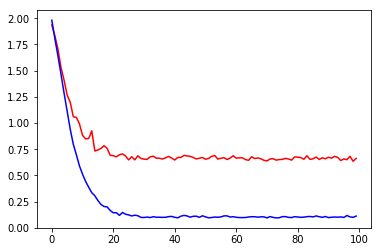

In [16]:
main()

In [17]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*14, 117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)+x1 #Resnet1
        x = self.conv2_2(x)
        #x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.6304] [Train Acc: 0.8031] [Valid Loss: 0.9848] [Valid Acc: 0.6250]
Epoch    18: reducing learning rate of group 0 to 1.2000e-04.
[Epoch 20/100] [Train Loss: 0.2774] [Train Acc: 0.9258] [Valid Loss: 0.7718] [Valid Acc: 0.7188]
[Epoch 30/100] [Train Loss: 0.2455] [Train Acc: 0.9313] [Valid Loss: 0.7765] [Valid Acc: 0.7063]
Epoch    30: reducing learning rate of group 0 to 2.4000e-05.
Epoch    34: reducing learning rate of group 0 to 4.8000e-06.
Epoch    39: reducing learning rate of group 0 to 9.6000e-07.
[Epoch 40/100] [Train Loss: 0.2226] [Train Acc: 0.9453] [Valid Loss: 0.7465] [Valid Acc: 0.7500]
Epoch    43: reducing learning rate of group 0 to 1.9200e-07.
Epoch    47: reducing learning rate of group 0 to 3.8400e-08.
[Epoch 50/100] [Train Loss: 0.2285] [Train Acc: 0.9352] [Valid Loss: 0.7434] [Valid Acc: 0.7438]
Epoch    51: reducing learning rate of group 0 to 7.6800e-09.
[Epoch 60/100] [Train Loss: 0.2165] [Train Acc: 0.9437] [Valid 

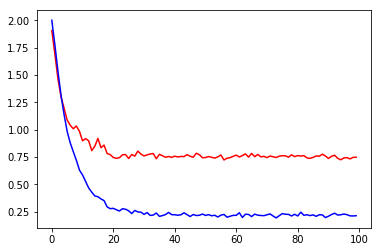

In [18]:
main()

In [19]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*14, 117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = self.conv2_2(x)
        #x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

In [6]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*14, 117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = self.conv2_1(x)
        #x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.8855] [Train Acc: 0.6992] [Valid Loss: 1.2802] [Valid Acc: 0.5500]
[Epoch 20/100] [Train Loss: 0.5612] [Train Acc: 0.8273] [Valid Loss: 0.9621] [Valid Acc: 0.6813]
Epoch    28: reducing learning rate of group 0 to 1.2000e-04.
[Epoch 30/100] [Train Loss: 0.2916] [Train Acc: 0.9164] [Valid Loss: 0.8600] [Valid Acc: 0.7500]
[Epoch 40/100] [Train Loss: 0.2531] [Train Acc: 0.9266] [Valid Loss: 0.8309] [Valid Acc: 0.7250]
Epoch    42: reducing learning rate of group 0 to 2.4000e-05.
Epoch    46: reducing learning rate of group 0 to 4.8000e-06.
[Epoch 50/100] [Train Loss: 0.2245] [Train Acc: 0.9445] [Valid Loss: 0.8194] [Valid Acc: 0.7625]
Epoch    50: reducing learning rate of group 0 to 9.6000e-07.
Epoch    54: reducing learning rate of group 0 to 1.9200e-07.
Epoch    58: reducing learning rate of group 0 to 3.8400e-08.
[Epoch 60/100] [Train Loss: 0.2318] [Train Acc: 0.9305] [Valid Loss: 0.8185] [Valid Acc: 0.7562]
Epoch    62: reducing learni

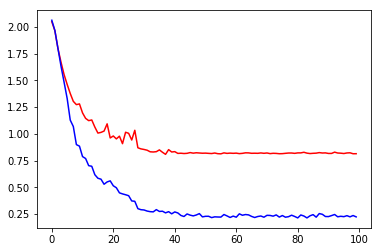

In [22]:
main()

In [23]:
hparams.feature_path = 'feature3'

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.5822] [Train Acc: 0.8090] [Valid Loss: 1.0514] [Valid Acc: 0.6813]
[Epoch 20/100] [Train Loss: 0.3487] [Train Acc: 0.8895] [Valid Loss: 0.8150] [Valid Acc: 0.7750]
Epoch    24: reducing learning rate of group 0 to 1.2000e-04.
[Epoch 30/100] [Train Loss: 0.1895] [Train Acc: 0.9430] [Valid Loss: 0.7156] [Valid Acc: 0.7812]
[Epoch 40/100] [Train Loss: 0.1672] [Train Acc: 0.9496] [Valid Loss: 0.6970] [Valid Acc: 0.7875]
Epoch    42: reducing learning rate of group 0 to 2.4000e-05.
Epoch    46: reducing learning rate of group 0 to 4.8000e-06.
[Epoch 50/100] [Train Loss: 0.1460] [Train Acc: 0.9578] [Valid Loss: 0.6917] [Valid Acc: 0.7812]
Epoch    50: reducing learning rate of group 0 to 9.6000e-07.
Epoch    54: reducing learning rate of group 0 to 1.9200e-07.
Epoch    58: reducing learning rate of group 0 to 3.8400e-08.
[Epoch 60/100] [Train Loss: 0.1366] [Train Acc: 0.9613] [Valid Loss: 0.6999] [Valid Acc: 0.7750]
Epoch    62: reducing learni

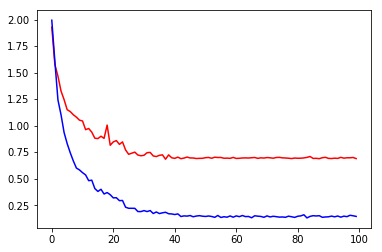

In [24]:
main()

In [6]:
hparams.feature_path = 'feature4'

In [7]:
hparams.learning_rate=6*1e-4

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.2153] [Train Acc: 0.9445] [Valid Loss: 0.6809] [Valid Acc: 0.7875]
Epoch    14: reducing learning rate of group 0 to 1.2000e-04.
Epoch    18: reducing learning rate of group 0 to 2.4000e-05.
[Epoch 20/100] [Train Loss: 0.0562] [Train Acc: 0.9917] [Valid Loss: 0.7367] [Valid Acc: 0.8125]
Epoch    22: reducing learning rate of group 0 to 4.8000e-06.
Epoch    26: reducing learning rate of group 0 to 9.6000e-07.
[Epoch 30/100] [Train Loss: 0.0548] [Train Acc: 0.9893] [Valid Loss: 0.6831] [Valid Acc: 0.8125]
Epoch    30: reducing learning rate of group 0 to 1.9200e-07.
Epoch    34: reducing learning rate of group 0 to 3.8400e-08.
Epoch    38: reducing learning rate of group 0 to 7.6800e-09.
[Epoch 40/100] [Train Loss: 0.0534] [Train Acc: 0.9906] [Valid Loss: 0.7249] [Valid Acc: 0.8063]
[Epoch 50/100] [Train Loss: 0.0528] [Train Acc: 0.9922] [Valid Loss: 0.6986] [Valid Acc: 0.8063]
[Epoch 60/100] [Train Loss: 0.0511] [Train Acc: 0.9917] [Valid 

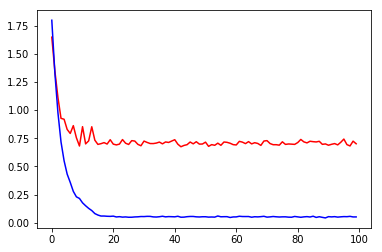

In [8]:
main()

In [6]:
'''
kaiming He init
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        self._initialize_weights()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(128, 96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(96),
        nn.ReLU(),
        nn.MaxPool1d(6, stride=6)
        )

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(96, 117),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)+x1 #Resnet1
        x = torch.cat((self.conv2_1(x)+self.conv2_2(x),self.conv2_2(x)+self.conv2_1(x)),2)
        x = self.conv3(x)
        x = x+x2#Resnet 2  
        x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                init.kaiming_normal(m.weight)
                if m.bias is not None:
                    init.constant(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                init.constant(m.weight, 1)
                init.constant(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal(m.weight, std=1e-3)
                if m.bias is not None:
                    init.constant(m.bias, 0)


In [8]:
hparams.learning_rate=1e-4
hparams.feature_path = 'feature4'

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.1643] [Train Acc: 0.7174] [Valid Loss: 1.3175] [Valid Acc: 0.5312]
[Epoch 20/100] [Train Loss: 0.5518] [Train Acc: 0.8719] [Valid Loss: 0.9449] [Valid Acc: 0.6500]
[Epoch 30/100] [Train Loss: 0.2927] [Train Acc: 0.9411] [Valid Loss: 0.8139] [Valid Acc: 0.7438]
Epoch    36: reducing learning rate of group 0 to 2.0000e-05.
[Epoch 40/100] [Train Loss: 0.1858] [Train Acc: 0.9648] [Valid Loss: 0.7972] [Valid Acc: 0.7562]
Epoch    41: reducing learning rate of group 0 to 4.0000e-06.
Epoch    47: reducing learning rate of group 0 to 8.0000e-07.
[Epoch 50/100] [Train Loss: 0.1818] [Train Acc: 0.9659] [Valid Loss: 0.7630] [Valid Acc: 0.7625]
Epoch    51: reducing learning rate of group 0 to 1.6000e-07.
Epoch    55: reducing learning rate of group 0 to 3.2000e-08.
Epoch    59: reducing learning rate of group 0 to 6.4000e-09.
[Epoch 60/100] [Train Loss: 0.1779] [Train Acc: 0.9685] [Valid Loss: 0.7933] [Valid Acc: 0.7438]
[Epoch 70/100] [Train Loss: 

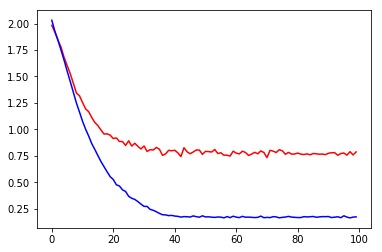

In [9]:
main()

In [9]:
hparams.learning_rate=2*1e-4

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.6001] [Train Acc: 0.8534] [Valid Loss: 0.9137] [Valid Acc: 0.6937]
[Epoch 20/100] [Train Loss: 0.1904] [Train Acc: 0.9628] [Valid Loss: 0.7245] [Valid Acc: 0.7250]
Epoch    25: reducing learning rate of group 0 to 4.0000e-05.
Epoch    29: reducing learning rate of group 0 to 8.0000e-06.
[Epoch 30/100] [Train Loss: 0.0897] [Train Acc: 0.9859] [Valid Loss: 0.7429] [Valid Acc: 0.7312]
Epoch    37: reducing learning rate of group 0 to 1.6000e-06.
[Epoch 40/100] [Train Loss: 0.0856] [Train Acc: 0.9878] [Valid Loss: 0.7294] [Valid Acc: 0.7375]
Epoch    41: reducing learning rate of group 0 to 3.2000e-07.
Epoch    45: reducing learning rate of group 0 to 6.4000e-08.
Epoch    49: reducing learning rate of group 0 to 1.2800e-08.
[Epoch 50/100] [Train Loss: 0.0903] [Train Acc: 0.9867] [Valid Loss: 0.6716] [Valid Acc: 0.7438]
Epoch    54: reducing learning rate of group 0 to 2.5600e-09.
[Epoch 60/100] [Train Loss: 0.0903] [Train Acc: 0.9872] [Valid 

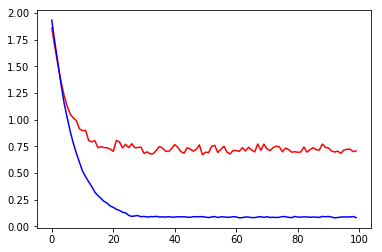

In [10]:
main()

In [7]:
hparams.feature_path = 'feature5'
hparams.learning_rate=5*1e-5

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.3442] [Train Acc: 0.6579] [Valid Loss: 1.4179] [Valid Acc: 0.5750]
[Epoch 20/100] [Train Loss: 0.7536] [Train Acc: 0.8220] [Valid Loss: 1.0285] [Valid Acc: 0.6438]
Epoch    28: reducing learning rate of group 0 to 1.0000e-05.
[Epoch 30/100] [Train Loss: 0.4542] [Train Acc: 0.8977] [Valid Loss: 0.9378] [Valid Acc: 0.6625]
Epoch    39: reducing learning rate of group 0 to 2.0000e-06.
[Epoch 40/100] [Train Loss: 0.4111] [Train Acc: 0.9059] [Valid Loss: 0.9379] [Valid Acc: 0.6500]
Epoch    46: reducing learning rate of group 0 to 4.0000e-07.
[Epoch 50/100] [Train Loss: 0.4045] [Train Acc: 0.9094] [Valid Loss: 0.8872] [Valid Acc: 0.6687]
Epoch    50: reducing learning rate of group 0 to 8.0000e-08.
[Epoch 60/100] [Train Loss: 0.3970] [Train Acc: 0.9083] [Valid Loss: 0.8907] [Valid Acc: 0.6625]
Epoch    61: reducing learning rate of group 0 to 1.6000e-08.
Epoch    65: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 70/100] [Train Loss: 

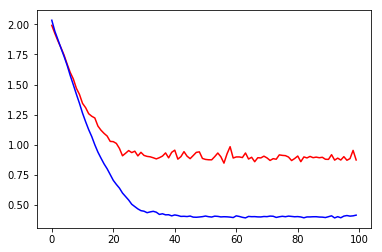

In [8]:
main()

In [6]:
torch.cuda.empty_cache() 

In [9]:
hparams.learning_rate=1e-4

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.8660] [Train Acc: 0.7031] [Valid Loss: 1.1782] [Valid Acc: 0.6188]
[Epoch 20/100] [Train Loss: 0.5428] [Train Acc: 0.8220] [Valid Loss: 0.9598] [Valid Acc: 0.7000]
[Epoch 30/100] [Train Loss: 0.3962] [Train Acc: 0.8725] [Valid Loss: 0.7854] [Valid Acc: 0.7812]
[Epoch 40/100] [Train Loss: 0.3024] [Train Acc: 0.9033] [Valid Loss: 0.7348] [Valid Acc: 0.7500]
[Epoch 50/100] [Train Loss: 0.2549] [Train Acc: 0.9176] [Valid Loss: 0.7004] [Valid Acc: 0.7500]
Epoch    56: reducing learning rate of group 0 to 2.0000e-05.
[Epoch 60/100] [Train Loss: 0.1771] [Train Acc: 0.9457] [Valid Loss: 0.6254] [Valid Acc: 0.7937]
Epoch    61: reducing learning rate of group 0 to 4.0000e-06.
Epoch    65: reducing learning rate of group 0 to 8.0000e-07.
Epoch    69: reducing learning rate of group 0 to 1.6000e-07.
[Epoch 70/100] [Train Loss: 0.1630] [Train Acc: 0.9523] [Valid Loss: 0.6234] [Valid Acc: 0.7937]
Epoch    73: reducing learning rate of group 0 to 3.200

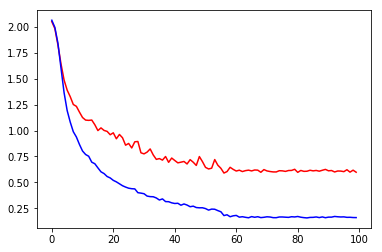

In [10]:
main()

In [12]:
torch.cuda.empty_cache()
hparams.feature_path = 'feature5'
hparams.learning_rate= 9*1e-5

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.8856] [Train Acc: 0.7759] [Valid Loss: 1.0337] [Valid Acc: 0.7000]
[Epoch 20/100] [Train Loss: 0.3541] [Train Acc: 0.9148] [Valid Loss: 0.7865] [Valid Acc: 0.7438]
Epoch    20: reducing learning rate of group 0 to 1.8000e-05.
[Epoch 30/100] [Train Loss: 0.2681] [Train Acc: 0.9427] [Valid Loss: 0.6656] [Valid Acc: 0.8375]
Epoch    31: reducing learning rate of group 0 to 3.6000e-06.
Epoch    35: reducing learning rate of group 0 to 7.2000e-07.
[Epoch 40/100] [Train Loss: 0.2509] [Train Acc: 0.9491] [Valid Loss: 0.6616] [Valid Acc: 0.8063]
Epoch    40: reducing learning rate of group 0 to 1.4400e-07.
Epoch    44: reducing learning rate of group 0 to 2.8800e-08.
Epoch    49: reducing learning rate of group 0 to 5.7600e-09.
[Epoch 50/100] [Train Loss: 0.2447] [Train Acc: 0.9504] [Valid Loss: 0.6384] [Valid Acc: 0.8375]
[Epoch 60/100] [Train Loss: 0.2501] [Train Acc: 0.9473] [Valid Loss: 0.6820] [Valid Acc: 0.8125]
[Epoch 70/100] [Train Loss: 

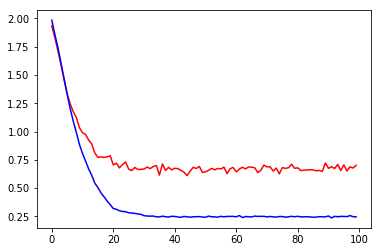

In [13]:
main()

In [8]:
torch.cuda.empty_cache()
hparams.batch_size = 30
hparams.learning_rate= 8*1e-5

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.1255] [Train Acc: 0.7311] [Valid Loss: 1.2308] [Valid Acc: 0.6250]
[Epoch 20/100] [Train Loss: 0.5445] [Train Acc: 0.8688] [Valid Loss: 0.8420] [Valid Acc: 0.7438]
[Epoch 30/100] [Train Loss: 0.2902] [Train Acc: 0.9370] [Valid Loss: 0.7378] [Valid Acc: 0.7688]
Epoch    37: reducing learning rate of group 0 to 1.6000e-05.
[Epoch 40/100] [Train Loss: 0.1892] [Train Acc: 0.9622] [Valid Loss: 0.7020] [Valid Acc: 0.7812]
Epoch    48: reducing learning rate of group 0 to 3.2000e-06.
[Epoch 50/100] [Train Loss: 0.1704] [Train Acc: 0.9684] [Valid Loss: 0.6995] [Valid Acc: 0.7875]
Epoch    55: reducing learning rate of group 0 to 6.4000e-07.
[Epoch 60/100] [Train Loss: 0.1644] [Train Acc: 0.9699] [Valid Loss: 0.6811] [Valid Acc: 0.7812]
Epoch    60: reducing learning rate of group 0 to 1.2800e-07.
Epoch    64: reducing learning rate of group 0 to 2.5600e-08.
Epoch    68: reducing learning rate of group 0 to 5.1200e-09.
[Epoch 70/100] [Train Loss: 

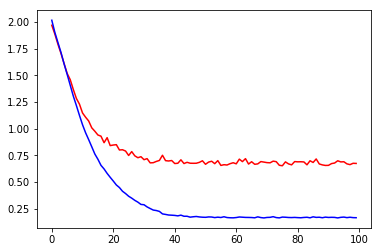

In [15]:
main()

In [26]:
# Wrapper class to run PyTorch model
class Runner(object):
    def __init__(self, hparams):
        self.model = Baseline(hparams)
        self.criterion = nn.CrossEntropyLoss()
        
       # self.optimizer = torch.optim.Adam(self.model.parameters(), lr=hparams.learning_rate)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=hparams.learning_rate, momentum=hparams.momentum)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=hparams.factor, patience=hparams.patience, verbose=True)
        self.learning_rate = hparams.learning_rate
        self.stopping_rate = hparams.stopping_rate
        self.device = torch.device("cpu")

        if hparams.device > 0:
            torch.cuda.set_device(hparams.device - 1)##
            self.model.cuda(hparams.device - 1)
            self.criterion.cuda(hparams.device - 1)
            self.device = torch.device("cuda:" + str(hparams.device - 1))
            
#         device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#         self.model = Baseline(hparams).to(device)
#         if torch.cuda.device_count() > 1:
#             print('\n===> Training on GPU!')
#             self.model = nn.DataParallel(net)

    # Accuracy function works like loss function in PyTorch
    def accuracy(self, source, target):
        source = source.max(1)[1].long().cpu()
        target = target.cpu()
        correct = (source == target).sum().item()

        return correct/float(source.size(0))

    # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
    def run(self, dataloader, mode='train'):
        self.model.train() if mode is 'train' else self.model.eval()

        epoch_loss = 0.0
        epoch_acc = 0.0
        
        for batch, (x, y) in enumerate(dataloader):
            x = x.to(self.device)
            y = y.to(self.device).type(torch.long)
            
            #print(y)

            prediction = self.model(x)
            loss = self.criterion(prediction, y)
            acc = self.accuracy(prediction, y)

            if mode is 'train':
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            epoch_loss += prediction.size(0)*loss.item()
            epoch_acc += prediction.size(0)*acc

        epoch_loss = epoch_loss/len(dataloader.dataset)
        epoch_acc = epoch_acc/len(dataloader.dataset)

        return epoch_loss, epoch_acc

    # Early stopping function for given validation loss
    def early_stop(self, loss, epoch):
        self.scheduler.step(loss, epoch)
        self.learning_rate = self.optimizer.param_groups[0]['lr']
        stop = self.learning_rate < self.stopping_rate

        return stop


In [28]:
torch.cuda.empty_cache()
hparams.feature_path = 'feature5'
hparams.batch_size = 30
hparams.learning_rate= 8*1e-5

Training on GPU:0
Epoch     9: reducing learning rate of group 0 to 1.6000e-05.
[Epoch 10/100] [Train Loss: 0.0571] [Train Acc: 0.9901] [Valid Loss: 0.6438] [Valid Acc: 0.7937]
Epoch    13: reducing learning rate of group 0 to 3.2000e-06.
[Epoch 20/100] [Train Loss: 0.0296] [Train Acc: 0.9964] [Valid Loss: 0.6656] [Valid Acc: 0.7875]
Epoch    21: reducing learning rate of group 0 to 6.4000e-07.
Epoch    25: reducing learning rate of group 0 to 1.2800e-07.
Epoch    29: reducing learning rate of group 0 to 2.5600e-08.
[Epoch 30/100] [Train Loss: 0.0267] [Train Acc: 0.9967] [Valid Loss: 0.6243] [Valid Acc: 0.8000]
Epoch    34: reducing learning rate of group 0 to 5.1200e-09.
[Epoch 40/100] [Train Loss: 0.0277] [Train Acc: 0.9969] [Valid Loss: 0.6467] [Valid Acc: 0.7875]
[Epoch 50/100] [Train Loss: 0.0264] [Train Acc: 0.9973] [Valid Loss: 0.6598] [Valid Acc: 0.7875]
[Epoch 60/100] [Train Loss: 0.0277] [Train Acc: 0.9967] [Valid Loss: 0.6407] [Valid Acc: 0.7875]
[Epoch 70/100] [Train Loss: 

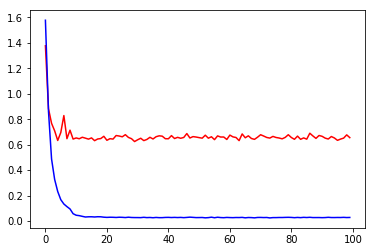

In [31]:
main()

In [38]:
seed = torch.initial_seed()
cuda_seed = torch.cuda.initial_seed()

In [23]:
seed = 1563868121
cuda_seed = 381692953686369
torch.manual_seed(seed)
torch.cuda.manual_seed_all(cuda_seed)

In [39]:
seed, cuda_seed

(1563868121, 381692953686369)

In [30]:
torch.cuda.empty_cache()
hparams.feature_path = 'feature5'
hparams.batch_size = 30
hparams.learning_rate= 1e-5

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.9782] [Train Acc: 0.8286] [Valid Loss: 1.1746] [Valid Acc: 0.6687]
[Epoch 20/100] [Train Loss: 0.4047] [Train Acc: 0.9362] [Valid Loss: 0.8157] [Valid Acc: 0.7562]
[Epoch 30/100] [Train Loss: 0.1894] [Train Acc: 0.9723] [Valid Loss: 0.6627] [Valid Acc: 0.8000]
Epoch    34: reducing learning rate of group 0 to 2.0000e-06.
Epoch    39: reducing learning rate of group 0 to 4.0000e-07.
[Epoch 40/100] [Train Loss: 0.1204] [Train Acc: 0.9848] [Valid Loss: 0.6402] [Valid Acc: 0.8125]
Epoch    43: reducing learning rate of group 0 to 8.0000e-08.
[Epoch 50/100] [Train Loss: 0.1183] [Train Acc: 0.9842] [Valid Loss: 0.6801] [Valid Acc: 0.7688]
Epoch    50: reducing learning rate of group 0 to 1.6000e-08.
Epoch    54: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 60/100] [Train Loss: 0.1167] [Train Acc: 0.9840] [Valid Loss: 0.6431] [Valid Acc: 0.8000]
[Epoch 70/100] [Train Loss: 0.1174] [Train Acc: 0.9849] [Valid Loss: 0.6314] [Valid Acc: 0

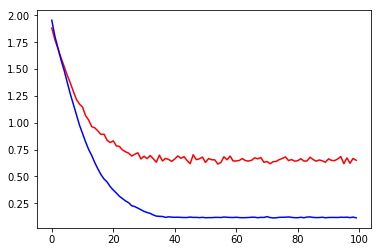

In [13]:
main()

In [42]:
torch.cuda.empty_cache()

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.9757] [Train Acc: 0.8262] [Valid Loss: 1.1628] [Valid Acc: 0.6687]
[Epoch 20/100] [Train Loss: 0.4038] [Train Acc: 0.9345] [Valid Loss: 0.8031] [Valid Acc: 0.7562]
[Epoch 30/100] [Train Loss: 0.1891] [Train Acc: 0.9721] [Valid Loss: 0.6468] [Valid Acc: 0.8125]
[Epoch 40/100] [Train Loss: 0.0995] [Train Acc: 0.9859] [Valid Loss: 0.6643] [Valid Acc: 0.8187]
[Epoch 50/100] [Train Loss: 0.0597] [Train Acc: 0.9914] [Valid Loss: 0.6961] [Valid Acc: 0.7688]
[Epoch 60/100] [Train Loss: 0.0351] [Train Acc: 0.9954] [Valid Loss: 0.6477] [Valid Acc: 0.8187]
[Epoch 70/100] [Train Loss: 0.0261] [Train Acc: 0.9953] [Valid Loss: 0.7098] [Valid Acc: 0.7937]
[Epoch 80/100] [Train Loss: 0.0170] [Train Acc: 0.9979] [Valid Loss: 0.6707] [Valid Acc: 0.8000]
[Epoch 90/100] [Train Loss: 0.0119] [Train Acc: 0.9986] [Valid Loss: 0.7739] [Valid Acc: 0.7750]
[Epoch 100/100] [Train Loss: 0.0085] [Train Acc: 0.9990] [Valid Loss: 0.7937] [Valid Acc: 0.7875]
Training Fi

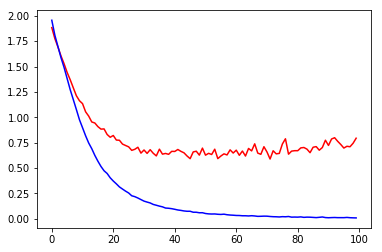

In [43]:
main()

In [38]:
torch.cuda.max_memory_allocated()

0

In [32]:
torch.cuda.memory_allocated()

0

In [33]:
torch.cuda.memory_cached()

0

In [34]:
torch.cuda.max_memory_cached()

0

In [31]:
torch.backends.cuda.cufft_plan_cache.clear()

In [6]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*14, 117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = self.conv2_1(x)
        #x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

In [7]:
torch.cuda.empty_cache()
hparams.feature_path = 'feature5'
hparams.batch_size = 40
hparams.learning_rate= 5*1e-5

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.4210] [Train Acc: 0.8618] [Valid Loss: 0.9211] [Valid Acc: 0.7125]
[Epoch 20/100] [Train Loss: 0.2449] [Train Acc: 0.9246] [Valid Loss: 0.7479] [Valid Acc: 0.7750]
[Epoch 30/100] [Train Loss: 0.1727] [Train Acc: 0.9469] [Valid Loss: 0.7212] [Valid Acc: 0.7937]
[Epoch 40/100] [Train Loss: 0.1182] [Train Acc: 0.9626] [Valid Loss: 0.6745] [Valid Acc: 0.7875]
[Epoch 50/100] [Train Loss: 0.0943] [Train Acc: 0.9711] [Valid Loss: 0.7082] [Valid Acc: 0.7750]
[Epoch 60/100] [Train Loss: 0.0693] [Train Acc: 0.9775] [Valid Loss: 0.6915] [Valid Acc: 0.7750]
[Epoch 70/100] [Train Loss: 0.0551] [Train Acc: 0.9815] [Valid Loss: 0.7897] [Valid Acc: 0.7438]
[Epoch 80/100] [Train Loss: 0.0446] [Train Acc: 0.9858] [Valid Loss: 0.6649] [Valid Acc: 0.8125]
[Epoch 90/100] [Train Loss: 0.0410] [Train Acc: 0.9874] [Valid Loss: 0.7226] [Valid Acc: 0.8000]
[Epoch 100/100] [Train Loss: 0.0320] [Train Acc: 0.9911] [Valid Loss: 0.7098] [Valid Acc: 0.8187]
Training Fi

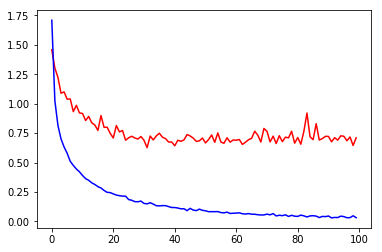

In [8]:
main()

In [9]:
torch.cuda.empty_cache()
hparams.feature_path = 'feature5'
hparams.batch_size = 30
hparams.learning_rate= 2*1e-5

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.6182] [Train Acc: 0.7983] [Valid Loss: 1.0345] [Valid Acc: 0.6500]
[Epoch 20/100] [Train Loss: 0.4136] [Train Acc: 0.8646] [Valid Loss: 0.9419] [Valid Acc: 0.7000]
[Epoch 30/100] [Train Loss: 0.3119] [Train Acc: 0.8997] [Valid Loss: 0.8251] [Valid Acc: 0.7750]
[Epoch 40/100] [Train Loss: 0.2351] [Train Acc: 0.9288] [Valid Loss: 0.7699] [Valid Acc: 0.7500]
[Epoch 50/100] [Train Loss: 0.1916] [Train Acc: 0.9375] [Valid Loss: 0.7175] [Valid Acc: 0.7625]
[Epoch 60/100] [Train Loss: 0.1570] [Train Acc: 0.9492] [Valid Loss: 0.7229] [Valid Acc: 0.7438]
[Epoch 70/100] [Train Loss: 0.1316] [Train Acc: 0.9594] [Valid Loss: 0.7009] [Valid Acc: 0.7812]
[Epoch 80/100] [Train Loss: 0.1057] [Train Acc: 0.9654] [Valid Loss: 0.6882] [Valid Acc: 0.7625]
[Epoch 90/100] [Train Loss: 0.0948] [Train Acc: 0.9701] [Valid Loss: 0.6412] [Valid Acc: 0.8125]
[Epoch 100/100] [Train Loss: 0.0845] [Train Acc: 0.9714] [Valid Loss: 0.6404] [Valid Acc: 0.8000]
Training Fi

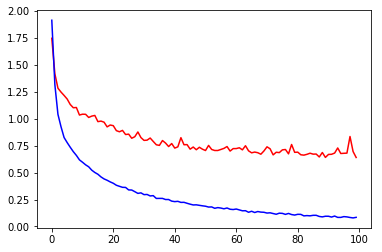

In [11]:
main()

In [13]:
hparams.batch_size = 30
hparams.learning_rate= 8*1e-6

In [14]:
torch.cuda.empty_cache()

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.8727] [Train Acc: 0.7010] [Valid Loss: 1.2192] [Valid Acc: 0.6125]
[Epoch 20/100] [Train Loss: 0.6527] [Train Acc: 0.7803] [Valid Loss: 1.1041] [Valid Acc: 0.6438]
[Epoch 30/100] [Train Loss: 0.5498] [Train Acc: 0.8253] [Valid Loss: 1.0250] [Valid Acc: 0.6687]
[Epoch 40/100] [Train Loss: 0.4703] [Train Acc: 0.8490] [Valid Loss: 0.9679] [Valid Acc: 0.7063]
[Epoch 50/100] [Train Loss: 0.4086] [Train Acc: 0.8708] [Valid Loss: 0.9211] [Valid Acc: 0.7063]
[Epoch 60/100] [Train Loss: 0.3558] [Train Acc: 0.8871] [Valid Loss: 0.8533] [Valid Acc: 0.7188]
[Epoch 70/100] [Train Loss: 0.3127] [Train Acc: 0.8995] [Valid Loss: 0.7846] [Valid Acc: 0.7562]
Epoch    75: reducing learning rate of group 0 to 1.6000e-06.
[Epoch 80/100] [Train Loss: 0.2801] [Train Acc: 0.9108] [Valid Loss: 0.7744] [Valid Acc: 0.7562]
Epoch    80: reducing learning rate of group 0 to 3.2000e-07.
Epoch    84: reducing learning rate of group 0 to 6.4000e-08.
Epoch    88: reducin

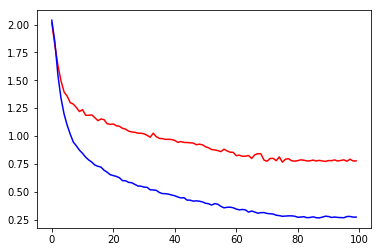

In [15]:
main()

In [16]:
torch.cuda.empty_cache()

In [18]:
class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        self._initialize_weights()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*14, 117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = self.conv2_1(x)
        #x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                init.kaiming_normal(m.weight)
                if m.bias is not None:
                    init.constant(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                init.constant(m.weight, 1)
                init.constant(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal(m.weight, std=1e-3)
                if m.bias is not None:
                    init.constant(m.bias, 0)
                    


In [19]:
hparams.learning_rate= 1e-5

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.7779] [Train Acc: 0.7355] [Valid Loss: 1.1770] [Valid Acc: 0.6250]
[Epoch 20/100] [Train Loss: 0.5646] [Train Acc: 0.8221] [Valid Loss: 1.0263] [Valid Acc: 0.6750]
[Epoch 30/100] [Train Loss: 0.4564] [Train Acc: 0.8542] [Valid Loss: 0.9270] [Valid Acc: 0.7375]
[Epoch 40/100] [Train Loss: 0.3663] [Train Acc: 0.8818] [Valid Loss: 0.8597] [Valid Acc: 0.7000]
Epoch    47: reducing learning rate of group 0 to 2.0000e-06.
[Epoch 50/100] [Train Loss: 0.3177] [Train Acc: 0.8997] [Valid Loss: 0.8283] [Valid Acc: 0.7125]
Epoch    53: reducing learning rate of group 0 to 4.0000e-07.
Epoch    57: reducing learning rate of group 0 to 8.0000e-08.
[Epoch 60/100] [Train Loss: 0.3063] [Train Acc: 0.8999] [Valid Loss: 0.8202] [Valid Acc: 0.7250]
Epoch    62: reducing learning rate of group 0 to 1.6000e-08.
[Epoch 70/100] [Train Loss: 0.3027] [Train Acc: 0.9039] [Valid Loss: 0.8245] [Valid Acc: 0.7188]
Epoch    71: reducing learning rate of group 0 to 3.200

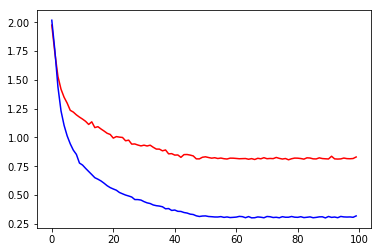

In [20]:
main()

In [21]:
torch.cuda.empty_cache()
hparams.learning_rate= 3*1e-6

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.4896] [Train Acc: 0.4805] [Valid Loss: 1.6017] [Valid Acc: 0.4938]
[Epoch 20/100] [Train Loss: 1.0277] [Train Acc: 0.6470] [Valid Loss: 1.2920] [Valid Acc: 0.6188]
[Epoch 30/100] [Train Loss: 0.8470] [Train Acc: 0.7156] [Valid Loss: 1.1657] [Valid Acc: 0.6250]
[Epoch 40/100] [Train Loss: 0.7552] [Train Acc: 0.7534] [Valid Loss: 1.1226] [Valid Acc: 0.6312]
[Epoch 50/100] [Train Loss: 0.6792] [Train Acc: 0.7796] [Valid Loss: 1.0612] [Valid Acc: 0.6562]
Epoch    56: reducing learning rate of group 0 to 6.0000e-07.
[Epoch 60/100] [Train Loss: 0.6297] [Train Acc: 0.7940] [Valid Loss: 1.0301] [Valid Acc: 0.6500]
Epoch    61: reducing learning rate of group 0 to 1.2000e-07.
Epoch    65: reducing learning rate of group 0 to 2.4000e-08.
[Epoch 70/100] [Train Loss: 0.6238] [Train Acc: 0.8034] [Valid Loss: 1.0325] [Valid Acc: 0.6750]
Epoch    77: reducing learning rate of group 0 to 4.8000e-09.
[Epoch 80/100] [Train Loss: 0.6250] [Train Acc: 0.8016]

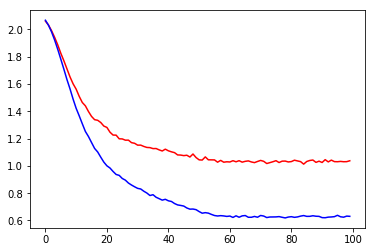

In [22]:
main()

In [36]:
torch.cuda.empty_cache()
hparams.feature_path = 'feature5'
hparams.batch_size = 30
hparams.learning_rate= 5*1e-5

In [37]:
main()

MemoryError: 